## **Trabajo Práctico Final Grupal: Telco Churn**
____
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Ciencia de Datos - Curso I5571__
____

- Nombre: Nicolás
- Apellido: Paikovsky
- Legajo: 177.981-3

En este trabajo desarrollaremos un pipeline de Machine Learning para predecir la variable Churn (si el cliente se va a ir de la compañia o no)

#### Variables:
 - SeniorCitizien:	Si el cliente es un SeniorCitizien o no
 - tenure:	Antigüedad del cliente
 - PhoneService:	Si el cliente tiene un servicio de telefono o no
 - MultipleLines:	Si el cliente tiene multiples lineas o no
 - InternetService:	Tipo de servicio de internet que recibe. Si es que recibe
 - OnlineSecurity:	Si el cliente tiene un servicio de seguridad online o no
 - OnlineBackup:	Si el cliente tiene un servicio de backup o no.
 - DeviceProtection:	Si el cliente tiene un seguro del dispositivo o no
 - TechSupport:	Si el cliente tiene soporte de tecnología o no.
 - StreamingTV:	Si el cliente tiene servicio de streaming o no
 - StreamingMovies:	Si el cliente tiene servicios de streaming de peliculas o no
 - Contract:	Tipo de contrato del cliente
 - PaymentMethod:	Tipo de pago del cliente
 - MonthlyCharges:	Costo mensual
 - TotalCharges:	Cargos totales
 - Churn:	Si el cliente se fue de la compañía o no 

In [1]:
## Importo librerías de maniupulación de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Importo librerías de Aprendizaje automático
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, roc_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [3]:
# Importamos el dataset e imprimimos algunos registros
rawdata = pd.read_csv("./telco_churn_clusterai_v1.csv")
rawdata.head()

,SeniorCitizen,Partner,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,1.0,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.850000,29.85,No
1,0,No,34.0,Yes,No,Unknown,Yes,No,Yes,No,No,No,One year,Mailed check,55.573529,1889.50,No
2,0,No,2.0,No,No,Unknown,Yes,No,No,No,No,No,Month-to-month,Mailed check,53.850000,108.15,Yes
3,0,No,44.0,No,No,Unknown,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),42.300000,1840.75,No
4,0,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,75.825000,151.65,Yes


In [4]:
#usando np.shape podemos ver las dimensiones del dataset, nos dice que tiene 6842 renglones y 17 columnas
np.shape(rawdata)

(6842, 17)

____
**Usaremos una Regresión Logística como modelo base y un Random Forest como modelo de alto rendimiento.**

Transformar las variables object binarias con LabelEncoder y las nominales con One-Hot Encoding.


In [5]:
# Variables binarias que se pueden codificar como 0/1 (Label Encoding)
binary_cols = [ 'Partner', 'PhoneService', 'Churn']

le = LabelEncoder()
for col in binary_cols:
    # Usar LabelEncoder para convertir a 0/1
    rawdata[col] = le.fit_transform(rawdata[col])

# Variables categóricas nominales (One-Hot Encoding)
nominal_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                'StreamingMovies', 'Contract', 'PaymentMethod']

# Aplicamos One-Hot Encoding y eliminamos la primera columna para evitar multicolinealidad
data = pd.get_dummies(rawdata, columns=nominal_cols, drop_first=True)

print("Dimensiones finales del dataset:", data.shape)
data.head()

Dimensiones finales del dataset: (6842, 24)


,SeniorCitizen,Partner,tenure,PhoneService,MonthlyCharges,TotalCharges,Churn,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,Contract_Unknown,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Unknown
0,0,1,1.0,0,29.850000,29.85,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0,0,34.0,1,55.573529,1889.50,0,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,0,2.0,0,53.850000,108.15,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,0,44.0,0,42.300000,1840.75,0,False,False,False,...,True,False,False,True,False,False,False,False,False,False
4,0,0,2.0,1,75.825000,151.65,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False


Separamos la variable objetivo, dividimos los datos y escalamos las features numéricas.

In [6]:
# Separamos las X (features) e y (target)
X = data.drop('Churn', axis=1)
y = data['Churn'] # Churn (0=No, 1=Yes)

# Dividimos en conjuntos de entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y 
)

# Escalamos variables numéricas
scaler = StandardScaler()

# Columnas a estandarizar (tenure, MonthlyCharges, TotalCharges)
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Datos listos para el modelado.")

Datos listos para el modelado.


Establecemos una línea base de rendimiento. 
Usaremos el AUC-ROC (Área bajo la curva ROC) como métrica principal, ya que es la mejor para clasificación desbalanceada.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Definimos y entrenamos el modelo
logreg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
logreg.fit(X_train, y_train)

# Predicción de probabilidades (necesario para AUC)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# Evaluación
auc_logreg = roc_auc_score(y_test, y_prob_logreg)
print(f"AUC (Regresión Logística): {auc_logreg:.4f}")

# Evaluación binaria simple para reporte
y_pred_logreg = logreg.predict(X_test)
print("\nReporte de Clasificación (LogReg):")
print(classification_report(y_test, y_pred_logreg))

AUC (Regresión Logística): 0.8311

Reporte de Clasificación (LogReg):
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1507
           1       0.50      0.76      0.61       546

    accuracy                           0.74      2053
   macro avg       0.70      0.75      0.71      2053
weighted avg       0.79      0.74      0.75      2053



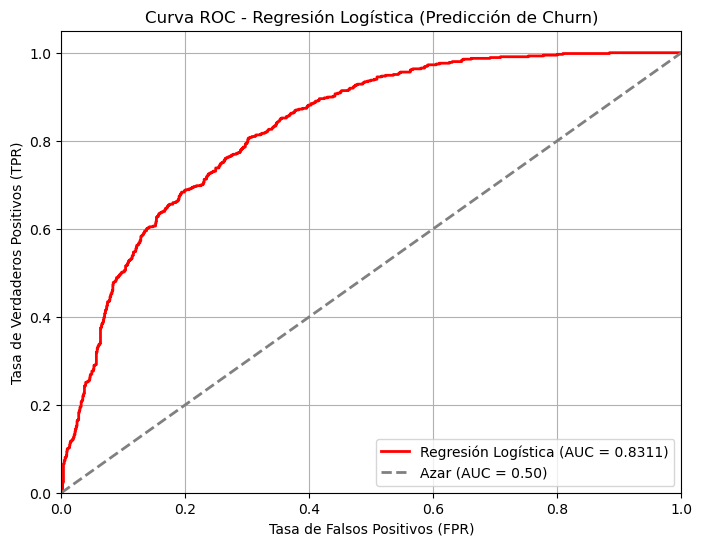

In [8]:
# Calcular FPR y TPR
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Generar el Gráfico
plt.figure(figsize=(8, 6))

# Curva ROC de la Regresión Logística
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, 
         label=f'Regresión Logística (AUC = {roc_auc_logreg:.4f})')

# Línea de referencia (clasificador aleatorio, AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Azar (AUC = 0.50)')

# 3. Configuración y Títulos
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística (Predicción de Churn)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Mejorar el rendimiento de la línea base usando un modelo de ensemble.

In [9]:
# Definir la cuadrícula de hiperparámetros (reducida para velocidad)
param_grid_rf = {
    'n_estimators': [100, 200], # Número de árboles
    'max_depth': [5, 10],      # Profundidad máxima del árbol
    'min_samples_split': [5, 10], # Mínimo de muestras para dividir un nodo
}

# Definir GridSearch (optimizando por ROC AUC)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("Iniciando GridSearch para Random Forest...")
grid_search_rf.fit(X_train, y_train)
print("GridSearch para Random Forest finalizado.")

# Evaluación del mejor modelo
best_rf = grid_search_rf.best_estimator_
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"\nMejores Hiperparámetros (RF): {grid_search_rf.best_params_}")
print(f"AUC (Random Forest): {auc_rf:.4f}")

# Comparación con la línea base
print(f"\nResultado Final: Random Forest (AUC={auc_rf:.4f}) {'> Regresión Logística' if auc_rf > auc_logreg else '<= Regresión Logística'}")

Iniciando GridSearch para Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearch para Random Forest finalizado.

Mejores Hiperparámetros (RF): {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
AUC (Random Forest): 0.8418

Resultado Final: Random Forest (AUC=0.8418) > Regresión Logística


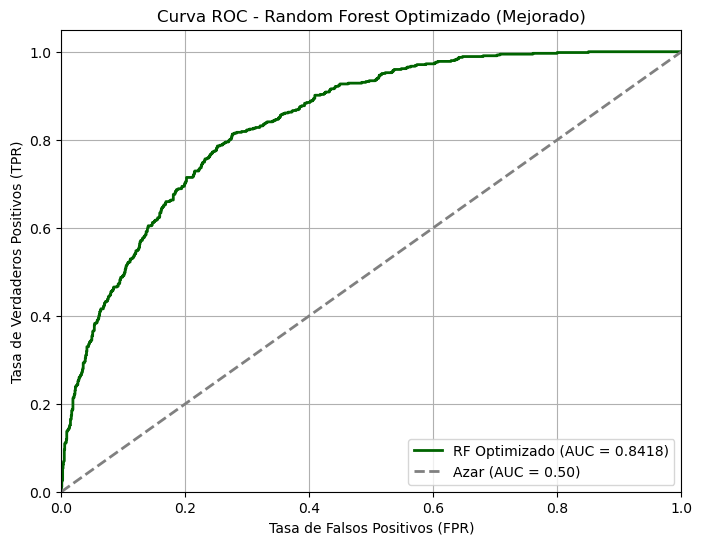

In [10]:
# Calcular FPR y TPR para el Random Forest Optimizado
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf) # Usamos el AUC ya calculado (auc_rf) para la etiqueta

# Generar el Gráfico
plt.figure(figsize=(8, 6))

# Curva ROC del Modelo Random Forest Optimizado
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, 
         label=f'RF Optimizado (AUC = {roc_auc_rf:.4f})')

# Línea de referencia (clasificador aleatorio, AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Azar (AUC = 0.50)')

# Configuración y Títulos
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest Optimizado (Mejorado)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

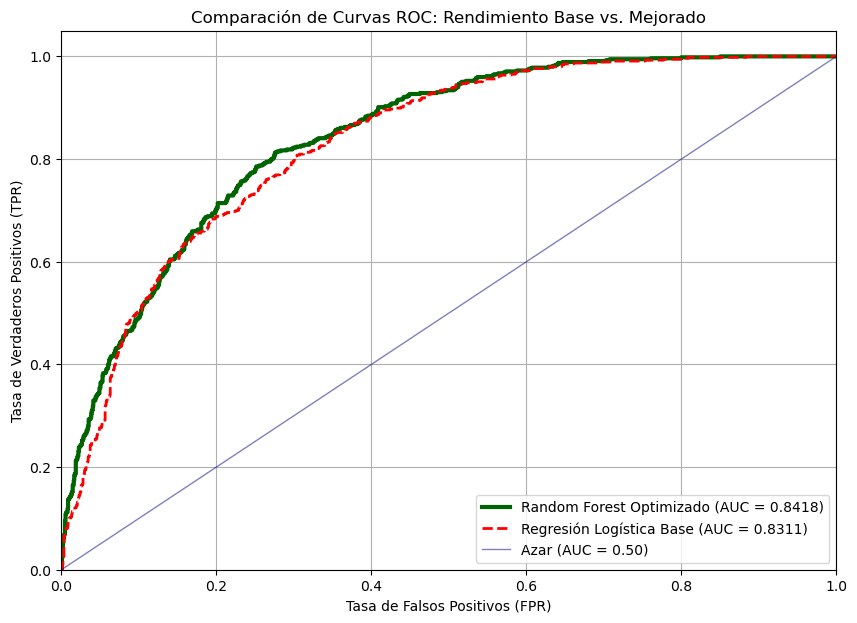

In [11]:
# --- Calcular FPR, TPR y AUC para AMBOS Modelos ---

# Regresión Logística (Inicial)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Random Forest Optimizado (Mejorado)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# --- Generar el Gráfico Conjunto ---

plt.figure(figsize=(10, 7))

# Random Forest Optimizado (Mejorado)
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=3, 
         label=f'Random Forest Optimizado (AUC = {roc_auc_rf:.4f})')

# Regresión Logística (Inicial/Base)
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, linestyle='--',
         label=f'Regresión Logística Base (AUC = {roc_auc_logreg:.4f})')

# Línea de referencia (Clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='-', alpha=0.5, label='Azar (AUC = 0.50)')

# --- 3. Configuración y Títulos ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC: Rendimiento Base vs. Mejorado')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

____
A continuación, se presenta un pipeline completo en Python para predecir la variable binaria Churn (Clasificación), incluyendo la aplicación de Análisis de Componentes Principales (PCA) para la reducción de dimensionalidad.
____

In [12]:
# Importamos el dataset e imprimimos algunos registros
rawdata = pd.read_csv("./telco_churn_clusterai_v1.csv")


# Separar Features (X) y Target (y)
X = rawdata.drop('Churn', axis=1)
# Convertir 'Churn' a binario (0/1) antes de la división
y = rawdata['Churn'].map({'No': 0, 'Yes': 1}) 

# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y 
)

Usamos ColumnTransformer para aplicar diferentes pasos de preprocesamiento a distintos subconjuntos de columnas.

In [13]:
# Columnas Numéricas a imputar y escalar (tenure, MonthlyCharges, TotalCharges)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Columnas Categóricas (Binarias) para Label/Ordinal Encoding (Yes/No, etc.)
# Usamos OrdinalEncoder en el pipeline para convertirlas a 0/1
# Se debe especificar el orden de las categorías para la codificación.
binary_features = ['Partner', 'PhoneService']
binary_categories = [['No', 'Yes']] * len(binary_features)

# Columnas Categóricas (Nominales) para One-Hot Encoding
nominal_features = [ 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'Contract', 'PaymentMethod']

# --- Creación de los Transformers ---

# Pipeline para características numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Rellenar NaN con la mediana
    ('scaler', StandardScaler())                    # Escalar los valores
])

# Pipeline para características binarias
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Rellenar NaN con la moda
    ('ordinal', OrdinalEncoder(categories=binary_categories)) # Convertir 'No'->0, 'Yes'->1
])

# Pipeline para características nominales
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Rellenar NaN con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # One-Hot y remover la primera categoría
])

# Combinar todos los transformers en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bin', binary_transformer, binary_features),
        ('nom', nominal_transformer, nominal_features)
    ],
    remainder='passthrough' # Mantiene otras columnas sin transformar (si las hay)
)

Entrenamos un RandomForestClassifier (Bosques Aleatorios) como modelo robusto.

In [14]:
# --- Definición del Pipeline Base ---
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

# --- Entrenamiento ---
print("Entrenando Pipeline Base (Sin PCA)...")
pipeline_base.fit(X_train, y_train)

# --- Evaluación ---
y_prob_base = pipeline_base.predict_proba(X_test)[:, 1]
auc_base = roc_auc_score(y_test, y_prob_base)

print(f"\n--- Resultados del Modelo Base (Random Forest) ---")
print(f"AUC-ROC: {auc_base:.4f}")

# Reporte detallado
y_pred_base = pipeline_base.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_base))


Entrenando Pipeline Base (Sin PCA)...

--- Resultados del Modelo Base (Random Forest) ---
AUC-ROC: 0.8243

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1507
           1       0.62      0.47      0.53       546

    accuracy                           0.78      2053
   macro avg       0.72      0.68      0.70      2053
weighted avg       0.77      0.78      0.77      2053



Insertamos un paso de PCA justo antes del clasificador para reducir el número de features a 15 (un valor arbitrario para demostrar la técnica).

In [15]:
# --- Definición del Pipeline con PCA ---
# El PCA debe ir DESPUÉS del preprocesamiento y escalamiento

n_components = 15 # Reducir a 15 componentes principales

pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_components, random_state=42)), # <-- Paso de PCA
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

# --- Entrenamiento ---
print("\nEntrenando Pipeline con PCA...")
pipeline_pca.fit(X_train, y_train)

# --- Evaluación ---
y_prob_pca = pipeline_pca.predict_proba(X_test)[:, 1]
auc_pca = roc_auc_score(y_test, y_prob_pca)

print(f"\n--- Resultados del Modelo con PCA (n={n_components}) ---")
print(f"AUC-ROC: {auc_pca:.4f}")

# Reporte detallado
y_pred_pca = pipeline_pca.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_pca))


Entrenando Pipeline con PCA...

--- Resultados del Modelo con PCA (n=15) ---
AUC-ROC: 0.8064

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1507
           1       0.62      0.43      0.50       546

    accuracy                           0.78      2053
   macro avg       0.71      0.67      0.68      2053
weighted avg       0.76      0.78      0.76      2053



**Comparación de Resultados**

In [16]:
print("\n=============================================")
print(f"Comparación Final de Modelos (AUC-ROC):")
print(f"1. Modelo Base (Sin PCA): {auc_base:.4f}")
print(f"2. Modelo con PCA (n={n_components}): {auc_pca:.4f}")
print("=============================================")


Comparación Final de Modelos (AUC-ROC):
1. Modelo Base (Sin PCA): 0.8243
2. Modelo con PCA (n=15): 0.8064


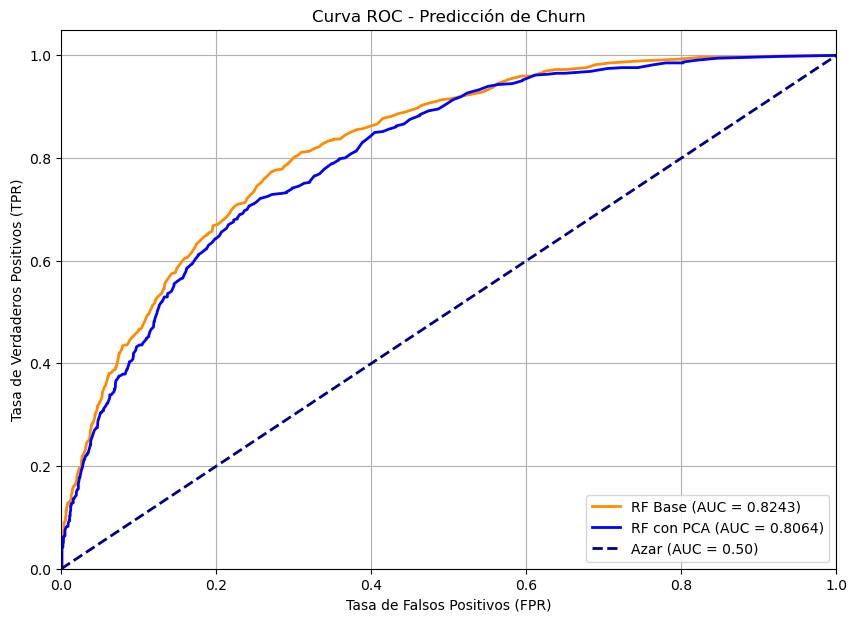

In [17]:
# --- Calcular FPR, TPR para AMBOS Modelos ---

# Modelo Base (sin PCA)
fpr_base, tpr_base, thresholds_base = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

# Modelo con PCA
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test, y_prob_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)

# --- Generar el Gráfico ---

plt.figure(figsize=(10, 7))

# Curva ROC del Modelo Base
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, 
         label=f'RF Base (AUC = {roc_auc_base:.4f})')

# Curva ROC del Modelo con PCA
plt.plot(fpr_pca, tpr_pca, color='blue', lw=2, 
         label=f'RF con PCA (AUC = {roc_auc_pca:.4f})')

# Línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.50)')

# --- Configuración y Títulos ---

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Predicción de Churn')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()